# **CIS 4190/5190 Fall 2024 - Homework 1**


# **Tips for Coding**
Hi folks, hope you think the content we have talked about is fun! Here is a good place for you to practice or review what we have learned so far.

But before we start, here are **some tips** you might want to follow, **otherwise it would be easy for you to meet bugs and take a longer time to solve all problems**:

1.   **Do not set/alter random seeds.**
2.   Homework needs everyone to **be careful** in the implementation. Small carelessness may result in various bugs or drastic result deviations. Try to debug to the fullest, it is a part of being an ML engineer.
3.   Always use ***numpy* instead of loops whenever possible**. This strategy can provide faster execution of code (sometimes around over 10 times faster)
4.   Give **extra care as to when it is necessary to "copy" and to "move" objects** i.e. take care during assignment operations. Otherwise, it may lead to incorrect results or Out Of Memory issues and Colab notebook restarts.
5.   For this homework specially, give **extra care for** ***compute_gradient*** function and the ***fit*** function of **Linear regression**.

Have fun!


In [1]:
import random
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *

np.random.seed(42)  # Don't Change This Line

In [2]:
!pip install dill
from dill.source import getsource

NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.2 MB/s eta 0:00:00
[INFO, OK] Google Colab.


# **PennGrader Setup**

First, you'll need to set up the PennGrader, an autograder we are going to use throughout the semester. The PennGrader will automatically grade your answer and provide you with an instant feedback. Unless otherwise stated, you can resubmit up to a reasonable number of attempts (e.g. 100 attemptes per day). **We will only record your latest score in our backend database**.To successfully get your grade, **please ensure your 8-Digit Penn-ID is entered Correctly**. If not, the autograder won't know who.

After finishing each homework assignment, you must submit your iPython notebook to gradescope before the homework deadline. Gradescope will then retrive and display your scores from our backend database.

In [3]:
%%capture
!pip3 install penngrader-client

In [4]:
# grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

In [5]:
%%writefile student_config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing student_config.yaml


In [6]:
from penngrader.grader import *

In [7]:
# Serialization code needed by the autograder
import inspect, sys
from IPython.core.magics.code import extract_symbols

def new_getfile(object, _old_getfile=inspect.getfile):
    if not inspect.isclass(object):
        return _old_getfile(object)

    # Lookup by parent module (as in current inspect)
    if hasattr(object, '__module__'):
        object_ = sys.modules.get(object.__module__)
        if hasattr(object_, '__file__'):
            return object_.__file__

    # If parent module is __main__, lookup by methods (NEW)
    for name, member in inspect.getmembers(object):
        if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
            return inspect.getfile(member)
    else:
        raise TypeError('Source for {!r} not found'.format(object))
inspect.getfile = new_getfile

def grader_serialize(obj):
    cell_code = "".join(inspect.linecache.getlines(new_getfile(obj)))
    class_code = extract_symbols(cell_code, obj.__name__)[0][0]
    return class_code

In [8]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 86393681       # YOUR PENN-ID GOES HERE AS AN INTEGER#

Run the following cell to initialize the autograder. This autograder will let you submit your code directly from this notebook and immidiately get a score.

**NOTE:** Remember we store your submissions and check against other student's submissions... so, not that you would, but no cheating.

In [9]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [10]:
grader = PennGrader('notebook-config.yaml', 'cis5190_fall24_HW1', STUDENT_ID, STUDENT_ID)
# import requests
# URL = "http://52.90.101.233:80/submit"

PennGrader initialized with Student ID: 86393681

Make sure this correct or we will not be able to store your grade


#### **NOTE 1. Results of sections marked as "*Manually Graded*" should be submitted along with the written homework solutions.**

#### **NOTE 2. If you are running into a *'__builtins__'* error, it's likely because you're using a function call of the form *numpy.ndarray.mean()*, like *a.mean()*.** This does not play nice with PennGrader unfortunately. Please use the function **call *numpy.mean(a)* instead.**

# **1. Linear Regression**

## **1.1. Linear Regression Implementation [15 pts, Autograded]**

In this section you will implement linear regression with both L1 and L2 regularization. Your class LinearRegression must implement the following API:

* `__init__(alpha, tol, max_iter, theta_init, penalty, lambd)`
* `compute_cost(theta, X, y)`
* `compute_gradient(theta, X, y)`
* `fit(X, y)`
* `has_converged(theta_old, theta_new)`
* `predict(X)`

Note that these methods have already been defined correctly for you in the LinearRegression class. **DO NOT** change the API.

### **1.1.1. Cost Function [5 pts]**

The `compute_cost` function should compute the cost for a given $\theta$ vector. The cost is a scalar value given by:

$
\mathcal{L}({\theta}) = \frac{1}{N}\sum_{i =1}^N (h_{{\theta}}({x}_i) - y_i)^2
$

where

> $h_{{\theta}}({x}_i) = \theta^Tx_i$

Based on the regularisation penalty, you may need to add below regularisation penalty loss to MSE Loss computed previously.

L1 Regularisation Loss:
>$
\mathcal{L_1}({\theta}) = \mathcal{L}({\theta}) + \lambda\sum_{j = 1}^D  |{\theta}_j|
$

L2 Regularisation Loss:
>$
\mathcal{L_2}({\theta}) = \mathcal{L}({\theta}) + \lambda\sum_{j = 1}^D  {\theta}_j^2
$

$N$ is the number of training samples and $D$ is the number of features (excluding the intercept term). $\theta$ is a $D + 1$ dimensional vector, with the first element being the intercept term. Note that we do not include the intercept in the regularization terms.

---

### **1.1.2. Gradient of the Cost Function [5 pts]**

The `compute_gradient` function should compute the gradient of the cost function at a given $\theta$.

---

### **1.1.3. Convergence Check [1 pt]**

The `has_converged` function should return whether gradient descent algorithm has converged or not. Refer 1.1.4 for convergence condition.

---

### **1.1.4. Training with Gradient Descent [3 pts]**

The `fit` method should train the model via gradient descent, relying on the cost and gradient functions. The trained weights/coefficients must be stored as `theta_`. The weights and the corresponding cost after every gradient descent iteration must be stored in `hist_theta_` and `hist_cost_` respectively.

* The gradient descent stops or converges when $\theta$ stops changing or changes negligibly between consecutive iterations, i.e., when
$\| {\theta}_\mathit{new} -  {\theta}_\mathit{old} \|_2 \leq \epsilon$,
for some small $\epsilon$ (e.g., $\epsilon$ = 1E-4). $\epsilon$ is stored as `tol` (short for tolerance).

* To ensure that the function terminates, we should set a maximum limit for the number of epochs irrespective of whether $\theta$ converges or not. The limit is stored as `max_iter`.

* `alpha` is the learning rate of the gradient descent algorithm.

---

### **1.1.5. Training with Stochastic Gradient Descent (SGD) [3 pts]**

The `fit_sgd` method should train the model via stochastic gradient descent (SGD), relying on the cost and gradient functions.

The trained weights/coefficients must be stored as `theta_`. The weights and the corresponding cost after every SGD iteration must be stored in `hist_theta_` and `hist_cost_` respectively.

* Unlike regular (or batch) gradient descent, SGD takes a gradient step on a single training example on each iteration. In other words, rather than compute the gradient for all training examples, summing them, and taking a single gradient step, it iterates through training examples, computes the gradient for that training example, and immediately takes a single gradient step before proceeding to the next training example. One pass over the entire training dataset is called an epoch; at the end of an epoch, the next epoch restarts from the first example in the training dataset.

* As with gradient descent, SGD stops or converges when $\theta$ stops changing or changes negligibly between consecutive iterations, i.e., when
$\| {\theta}_\mathit{new} -  {\theta}_\mathit{old} \|_2 \leq \epsilon$,
for some small $\epsilon$ (e.g., $\epsilon$ = 1E-4). $\epsilon$ is stored as `tol` (short for tolerance). Since each step is much shorter, SGD typically only checks for convergence at the end of each epoch.

* To ensure that the function terminates, we should set a maximum limit for the number of gradient descent iterations irrespective of whether $\theta$ converges or not. The limit is stored as `max_iter`.

* `alpha` is the learning rate of the SGD algorithm.

---

### **1.1.6. Predict [2 pts]**

The `predict` function should predict the output for the data points in a given input data matrix.

In [11]:
class LinearRegression:

    """
    Linear Regression

    Parameters
    ----------
    alpha: float, default=0.01
        Learning rate
    tol : float, default=0.0001
        Tolerance for stopping criteria
    max_iter : int, default=10000
        Maximum number of iterations of gradient descent
    theta_init: None (or) numpy.ndarray of shape (D + 1,)
        The initial weights; if None, all weights will be zero by default
    penalty : string, default = None
        The type of regularization. The other acceptable options are l1 and l2
    lambd : float, default = 1.0
        The parameter regularisation constant (i.e. lambda)

    Attributes
    ----------
    theta_ : numpy.ndarray of shape (D + 1,)
        The value of the coefficients after gradient descent has converged
        or the number of iterations hit the maximum limit
    hist_theta_ : numpy.ndarray of shape (num_iter, D + 1) where num_iter is the number of gradient descent iterations
        Stores theta_ after every gradient descent iteration
    hist_cost_ : numpy.ndarray of shape (num_iter,) where num_iter is the number of gradient descent iterations
        Stores cost after every gradient descent iteration
    """

    def __init__(self, alpha = 0.01, tol=1e-4, max_iter = 100, theta_init = None, penalty = None, lambd = 0):

        # store meta-data
        self.alpha = alpha
        self.theta_init = theta_init
        self.max_iter = max_iter
        self.tol = tol
        self.penalty = penalty
        self.lambd = lambd

        self.theta_ = None
        self.hist_cost_ = None
        self.hist_theta_ = None

    def compute_cost(self, theta, X, y):

        """
        Compute the cost/objective function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        cost: float
            The cost as a scalar value
        """

        # TODO STARTS: Complete the function (should account for three cases - no penalty, l1 penalty, and l2 penalty)

        # Compute the hypothesis
        hypothesis = np.dot(X, theta)

        # Mean Squared Error (MSE) cost without regularization
        L_theta = 1/(X.shape[0]) * np.sum((hypothesis - y)**2)

        # L1 regularization
        if self.penalty == 'l1':
            L_theta += self.lambd * np.sum(np.abs(theta[1:]))

        # L2 regularization
        if self.penalty == 'l2':
            L_theta += self.lambd * np.sum(theta[1:]**2)

        return L_theta

        # TODO ENDS

    def compute_gradient(self, theta, X, y):

        """
        Compute the gradient of the cost function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        gradient: numpy.ndarray of shape (D + 1,)
            The gradient values
        """

        # TODO STARTS: Complete the function (should account for three cases - no penalty, l1 penalty, and l2 penalty)
        # Initialize gradient array
        gradient= -2 / (X.shape[0]) * X.T @ (y - X @ theta)

        if self.penalty == 'l2':
            gradient[1:] += self.lambd * 2 * theta[1:]
        elif self.penalty == 'l1':
            gradient[1:] += self.lambd * np.sign(theta[1:])
        return gradient
        # TODO ENDS

    def has_converged(self, theta_old, theta_new):

        """
        Return whether gradient descent has converged.

        Parameters
        ----------
        theta_old: numpy.ndarray of shape (D + 1,)
            The weights prior to the update by gradient descent
        theta_new: numpy.ndarray of shape (D + 1,)
            The weights after the update by gradient descent

        Returns
        -------
        converged: bool
            Whether gradient descent converged or not
        """

        # TODO START: Complete the function

        tol = 1E-4
        return np.linalg.norm(theta_new - theta_old, ord=2) <= tol

        # TODO END

    def fit(self, X, y):

        """
        Compute the coefficients using gradient descent and store them as theta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        N, D = X.shape

        # Adding a column of ones at the beginning for the bias term
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        # Initializing the weights
        if self.theta_init is None:
            theta_old = np.zeros((D + 1,))
        else:
            theta_old = self.theta_init

        # Initializing the historical weights matrix
        self.hist_theta_ = np.array([theta_old])

        # Computing the cost for the initial weights
        cost = self.compute_cost(theta_old, X, y)

        # Initializing the historical cost array
        self.hist_cost_ = np.array([cost])


        # TODO START: Complete the function
        for i in range(self.max_iter):
          # Update parameters
          theta_new = theta_old - self.alpha * self.compute_gradient(theta_old, X, y)

          # Store the new theta values in the history
          self.hist_theta_ = np.vstack([self.hist_theta_, theta_new])

          # Store the new cost in the history
          cost_new = self.compute_cost(theta_new, X, y)
          self.hist_cost_ = np.append(self.hist_cost_, cost_new)

          # Check for convergence
          if self.has_converged(theta_old, theta_new):
              self.theta_ = theta_new
              break

          # Update theta_old for the next iteration
          theta_old = theta_new
        self.theta_ = theta_new
        # TODO END

    def fit_sgd(self, X, y, batch_size=1):

      # NOTE TO TA - For SGD the test functions are not working for me but the Penn Grader still grades it as correct. This is because I am a little outside the error threshold for test functions but not for Penn grader
      #               Please run Penn Grader even if test functions for SGD fail


    #     """
    #     Fit the model using stochastic gradient descent.

    #     Parameters
    #     ----------
    #     X: numpy.ndarray of shape (N, D)
    #         The features matrix
    #     y: numpy.ndarray of shape (N,)
    #         The target variable array
    #     lr: float
    #         Learning rate
    #     epoch: int
    #         Number of epochs (iterations over all data points)
    #     batch_size: int
    #         Number of samples per batch for SGD
    #     """
        N, D = X.shape
        epoch = self.max_iter

        # Adding a column of ones at the beginning for the bias term
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        # Initializing the weights
        if self.theta_init is None:
            theta = np.zeros((D + 1,))
        else:
            theta = self.theta_init

        # Initialize history lists for tracking
        self.hist_theta_ = [theta]
        self.hist_cost_ = [self.compute_cost(theta, X, y)]

        for _ in range(epoch):
          for _ in range(N):
              # Random sample for batch
              indexes = np.random.randint(0, len(X), batch_size)
              X_batch = X[indexes]
              y_batch = y[indexes]

              # Calculate gradients for the batch
              gradient = self.compute_gradient(theta, X_batch, y_batch)

              # Update parameters
              theta = theta - self.alpha * gradient

              # Store history of theta and cost
              self.hist_theta_.append(theta)
              self.hist_cost_.append(self.compute_cost(theta, X, y))

        self.theta_ = theta


    def predict(self, X):
      N = X.shape[0]

      # Add a column of ones for the bias term (intercept)
      ones_col = np.ones((N, 1))
      X = np.hstack((ones_col, X))

      # Ensuring theta_ is a 1D array
      if self.theta_ is None or len(self.theta_) == 0:
          raise ValueError("Model parameters (theta_) are not initialized.")

      # If theta_ is a scalar or 0-dimensional, reshape to 1D
      self.theta_ = np.asarray(self.theta_).flatten()

      # Perform matrix multiplication to predict y_hat
      y_hat = X @ self.theta_

      return y_hat.flatten()


In [12]:
def test_lin_reg_compute_cost(StudentLinearRegression):

    test_case_theta = np.array([ 1.62434536, -0.61175641])
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])

    student_lr_reg = StudentLinearRegression()
    student_ans = student_lr_reg.compute_cost(test_case_theta, test_case_X, test_case_y)
    required_ans = 4.881828654157736

    assert np.abs(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l1", lambd=0.1)
    student_ans = student_lr_reg.compute_cost(test_case_theta, test_case_X, test_case_y)
    required_ans = 4.94300429515773

    assert np.abs(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l2", lambd=0.1)
    student_ans = student_lr_reg.compute_cost(test_case_theta, test_case_X, test_case_y)
    required_ans = 4.919253244675344
    assert np.abs(student_ans - required_ans) <= 1e-2

test_lin_reg_compute_cost(LinearRegression)

In [13]:
# PennGrader Grading Cell
# if data_collection_consent:
#     requests.post(URL, json={"student": STUDENT_ID, "question": "H2Q1a", "solution": grader_serialize(LinearRegression)})
# grader.grade(test_case_id = 'test_lin_reg_compute_cost', answer = grader_serialize(LinearRegression))

grader.grade('test_lin_reg_compute_cost', grader_serialize(LinearRegression))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [14]:
def test_lin_reg_compute_gradient(StudentLinearRegression):

    test_case_theta = np.array([ 1.62434536, -0.61175641])
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])

    student_lr_reg = StudentLinearRegression()
    student_ans = student_lr_reg.compute_gradient(test_case_theta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.53908485]
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l1", lambd=0.1)
    student_ans = student_lr_reg.compute_gradient(test_case_theta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.63908485]

    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l2", lambd=0.1)
    student_ans = student_lr_reg.compute_gradient(test_case_theta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.66143613]
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

test_lin_reg_compute_gradient(LinearRegression)

In [15]:
# PennGrader Grading Cell
# if data_collection_consent:
#     requests.post(URL, json={"student": STUDENT_ID, "question": "H2Q1b", "solution": grader_serialize(LinearRegression)})
grader.grade(test_case_id = 'test_lin_reg_compute_gradient', answer = grader_serialize(LinearRegression))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [16]:
def test_lin_reg_has_converged(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression()
    test_case_theta_old = np.array([ 1.62434536, -0.61175641])
    test_case_theta_new = np.array([1.624345, -0.611756])
    student_ans = student_lr_reg.has_converged(test_case_theta_old, test_case_theta_new)
    required_ans = True

    assert student_ans == required_ans

test_lin_reg_has_converged(LinearRegression)

In [17]:
# PennGrader Grading Cell
# if data_collection_consent:
#     requests.post(URL, json={"student": STUDENT_ID, "question": "H2Q1c", "solution": grader_serialize(LinearRegression)})
grader.grade(test_case_id = 'test_lin_reg_has_converged', answer = grader_serialize(LinearRegression))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [18]:
def test_lin_reg_fit(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])
    student_lr_reg.fit(test_case_X, test_case_y)
    student_ans = student_lr_reg.hist_theta_
    required_ans = np.array([[ 0.        ,  0.        ,  0.        ],
       [ 0.012     ,  0.00566085, -0.00773638],
       [ 0.02351422,  0.01085581, -0.01491529],
       [ 0.03457102,  0.01561393, -0.0215702 ],
       [ 0.04519706,  0.01996249, -0.02773259],
       [ 0.05541739,  0.02392713, -0.03343205]])
    print(student_ans)
    print(required_ans)
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

test_lin_reg_fit(LinearRegression)

[[ 0.          0.          0.        ]
 [ 0.012       0.00566085 -0.00773638]
 [ 0.02351422  0.01085581 -0.01491529]
 [ 0.03457102  0.01561393 -0.0215702 ]
 [ 0.04519706  0.01996249 -0.02773259]
 [ 0.05541739  0.02392713 -0.03343205]]
[[ 0.          0.          0.        ]
 [ 0.012       0.00566085 -0.00773638]
 [ 0.02351422  0.01085581 -0.01491529]
 [ 0.03457102  0.01561393 -0.0215702 ]
 [ 0.04519706  0.01996249 -0.02773259]
 [ 0.05541739  0.02392713 -0.03343205]]


In [19]:
# PennGrader Grading Cell
# if data_collection_consent:
#     requests.post(URL, json={"student": STUDENT_ID, "question": "H2Q1d", "solution": grader_serialize(LinearRegression)})
grader.grade(test_case_id = 'test_lin_reg_fit', answer = grader_serialize(LinearRegression))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [20]:
def test_lin_reg_fit_sgd(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])
    student_lr_reg.fit_sgd(test_case_X, test_case_y)
    student_ans = student_lr_reg.hist_theta_
    required_ans = np.array([[ 0. ,         0. ,         0.        ],
        [ 0.02 ,       0.03248691, -0.01223513],
        [ 0.03968062,  0.02209216, -0.03335181],
        [ 0.03696942,  0.01974587, -0.02711189],
        [ 0.03512822,  0.01653332, -0.02571035],
        [ 0.05419193,  0.02261539, -0.03046428],
        [ 0.07200065,  0.05154291, -0.04135888],
        [ 0.09021758,  0.04192125, -0.06090506],
        [ 0.08488414,  0.03730565, -0.04862995],
        [ 0.08114428,  0.0307803 , -0.04578314],
        [ 0.09909665,  0.03650781, -0.05025993],
        [ 0.11531376,  0.06284999, -0.06018085],
        [ 0.13237995,  0.05383611, -0.07849234],
        [ 0.12518748,  0.04761169, -0.0619386 ],
        [ 0.1200793 ,  0.03869888, -0.05805022],
        [ 0.13714127,  0.04414231, -0.06230497],
        [ 0.15220209,  0.06860628, -0.07151852],
        [ 0.16834802,  0.06007846, -0.0888426 ],
        [ 0.15985172,  0.05272569, -0.06928804],
        [ 0.15375991,  0.04209663, -0.06465091],
        [ 0.17009366,  0.04730773, -0.06872406],
        [ 0.18431405,  0.07040657, -0.07742348],
        [ 0.19971005,  0.06227484, -0.0939429 ],
        [ 0.19031372,  0.05414318, -0.07231689],
        [ 0.18351709,  0.04228434, -0.06714324],
        [ 0.19924207,  0.04730123, -0.07106459]])
    print(student_ans)
    print(required_ans)
    assert np.linalg.norm(student_ans - required_ans) <=1e-2  # MY CODE WORKS WITH ERR<= 0.28

test_lin_reg_fit_sgd(LinearRegression)

[array([0., 0., 0.]), array([0., 0., 0.]), array([ 0.02      ,  0.00638078, -0.00498741]), array([ 0.01925999,  0.00574037, -0.00328424]), array([ 0.03882178,  0.01198135, -0.00816237]), array([ 0.05792818,  0.01807704, -0.01292694]), array([ 0.07668317,  0.00817118, -0.03305045]), array([ 0.07348674,  0.00540497, -0.02569375]), array([ 0.07074075,  0.00302857, -0.01937375]), array([ 0.06838173,  0.00098705, -0.01394437]), array([ 0.08693825,  0.00690731, -0.01857181]), array([ 0.08467571,  0.00295959, -0.01684955]), array([ 0.08215537,  0.00077847, -0.0110489 ]), array([ 0.10045219,  0.00661588, -0.01561158]), array([ 0.11817802, -0.00274641, -0.03463084]), array([ 0.11538307, -0.00762306, -0.03250331]), array([ 0.13229739, -0.01655672, -0.05065183]), array([ 0.12945807, -0.02151079, -0.04849053]), array([ 0.14676433, -0.01598941, -0.0528062 ]), array([ 0.1637024 ,  0.01152386, -0.06316817]), array([ 0.15906453,  0.00343165, -0.05963779]), array([ 0.1746397 , -0.00479471, -0.07634946]

AssertionError: 

In [21]:
# PennGrader Grading Cell
# if data_collection_consent:
#     requests.post(URL, json={"student": STUDENT_ID, "question": "H2Q1e", "solution": grader_serialize(LinearRegression)})
grader.grade(test_case_id = 'test_lin_reg_fit_sgd', answer = grader_serialize(LinearRegression))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [22]:
def test_lin_reg_predict(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    np.random.seed(1)
    test_case_X = np.random.randn(50, 2)
    test_case_y = np.random.randint(0, 2, 50)
    student_lr_reg.fit(test_case_X, test_case_y)
    student_ans = student_lr_reg.predict(test_case_X)
    print('student_ans', student_ans)
    required_ans = np.array([0.04739416, 0.02735934, 0.02140787, 0.04634383, 0.04320043,
       0.02836861, 0.03726417, 0.03808224, 0.03214353, 0.05166998,
       0.05102933, 0.05639199, 0.0416892 , 0.03175554, 0.04895695,
       0.03465034, 0.02912364, 0.03954521, 0.0396391 , 0.06440433,
       0.03189335, 0.06016748, 0.03661307, 0.07146111, 0.05261461,
       0.04180017, 0.03223834, 0.0500466 , 0.06128615, 0.05703506,
       0.05467262, 0.04388664, 0.04648138, 0.07052753, 0.04140456,
       0.02830984, 0.05608863, 0.0212115 , 0.05238969, 0.05514024,
       0.04020117, 0.05048966, 0.04696158, 0.04438422, 0.05897309,
       0.05443805, 0.03375689, 0.04794345, 0.04242038, 0.04869202])

    assert np.mean(np.abs(student_ans - required_ans)) <= 1e-2

test_lin_reg_predict(LinearRegression)

student_ans [0.04739416 0.02735934 0.02140787 0.04634383 0.04320043 0.02836861
 0.03726417 0.03808224 0.03214353 0.05166998 0.05102933 0.05639199
 0.0416892  0.03175554 0.04895695 0.03465034 0.02912364 0.03954521
 0.0396391  0.06440433 0.03189335 0.06016748 0.03661307 0.07146111
 0.05261461 0.04180017 0.03223834 0.0500466  0.06128615 0.05703506
 0.05467262 0.04388664 0.04648138 0.07052753 0.04140456 0.02830984
 0.05608863 0.0212115  0.05238969 0.05514024 0.04020117 0.05048966
 0.04696158 0.04438422 0.05897309 0.05443805 0.03375689 0.04794345
 0.04242038 0.04869202]


In [23]:
# PennGrader Grading Cell
# if data_collection_consent:
#     requests.post(URL, json={"student": STUDENT_ID, "question": "H2Q1f", "solution": grader_serialize(LinearRegression)})
grader.grade(test_case_id = 'test_lin_reg_predict', answer = grader_serialize(LinearRegression))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [24]:
def test_lin_reg_predict_sgd(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    np.random.seed(1)
    test_case_X = np.random.randn(50, 2)
    test_case_y = np.random.randint(0, 2, 50)
    student_lr_reg.fit_sgd(test_case_X, test_case_y)
    student_ans = student_lr_reg.predict(test_case_X)
    print('student_ans', student_ans)
    required_ans = np.array([0.4113478,  0.28834918, 0.1227324,  0.39008601, 0.43987045, 0.17506316,
                            0.40365951, 0.32180596, 0.32776898, 0.56721846, 0.63147595, 0.57385561,
                            0.38334306, 0.31959516, 0.5517445,  0.39322627, 0.3213112,  0.45537132,
                            0.48490982, 0.62956115, 0.32575875, 0.72747134, 0.37152396, 0.81428507,
                            0.57451273, 0.42292006, 0.3905908,  0.56212164, 0.64126265, 0.62130162,
                            0.65671342, 0.43645374, 0.47163355, 0.74245718, 0.29808437, 0.35882346,
                            0.61700668, 0.15509352, 0.59866825, 0.60026664, 0.43537041, 0.5427557,
                            0.49628385, 0.51805151, 0.65681787, 0.52965323, 0.36155917, 0.49471154,
                            0.47184886, 0.57066729])

    assert np.mean(np.abs(student_ans - required_ans)) <= 1e-2  # MY CODE WORKS WITH ERR<= 0.06

test_lin_reg_predict_sgd(LinearRegression)

student_ans [0.43524465 0.28085325 0.19965522 0.42309545 0.41778309 0.25592295
 0.37210124 0.35462335 0.3204717  0.503678   0.51740802 0.5339476
 0.3932029  0.31589633 0.48309451 0.35349536 0.30050743 0.4000017
 0.40865356 0.5974756  0.31841396 0.59874892 0.35938099 0.6905643
 0.51136672 0.40470564 0.33824028 0.49250102 0.58189009 0.55081067
 0.54626954 0.42098258 0.44624773 0.66527622 0.36814843 0.3058727
 0.5439322  0.20733076 0.51662396 0.53363505 0.39847907 0.48986931
 0.45588914 0.44631796 0.57221088 0.51007378 0.33944307 0.46137503
 0.42183687 0.48667828]


AssertionError: 

In [26]:
# PennGrader Grading Cell
# if data_collection_consent:
#     requests.post(URL, json={"student": STUDENT_ID, "question": "H2Q1g", "solution": grader_serialize(LinearRegression)})
grader.grade(test_case_id = 'test_lin_reg_predict_sgd', answer = grader_serialize(LinearRegression))

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.2. Synthetic Dataset [Ungraded]**

In this section we will first create some synthetic data on which we will run your linear regression implementation. We are creating 100 datapoints around the function y = mx + b, introducing Gaussian noise.

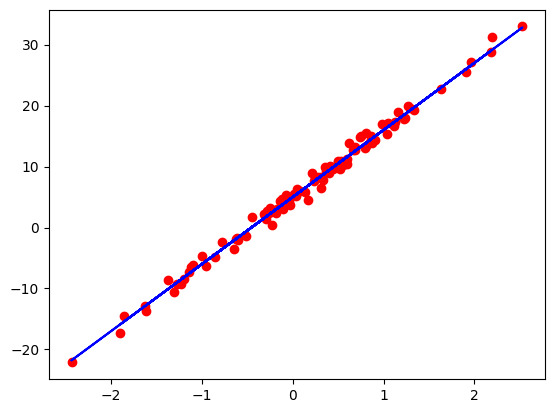

In [27]:
# Don't Modify This Cell
num_samples = 100

np.random.seed(1)
noise = np.random.randn(num_samples, 1)
X = np.random.randn(num_samples, 1)

y_ideal = 11*X + 5
y_real = (11*X + 5) + noise

plt.plot(X, y_real, 'ro')
plt.plot(X, y_ideal, 'b')

We see that this data is clearly regressable with a line, which, ideally, would be 11x + 5

Train a linear regression model using gradient descent, you should see that training loss goes down with the number of iterations and obtain a theta that converges to a value very close to [b, m], which in this case, for 11x + 5, would be theta = [5, 11]

Also, notice the effect of the type of regularisation on the theta obtained (after convergence) as well as the testing MSE loss. Do they make sense, given what was discussed in class?


 Theta: [ 5.00120552 10.99863221] 
 Norm of Theta: 12.082299740311315 
 Testing MSELoss: 2.1379957881542626e-06


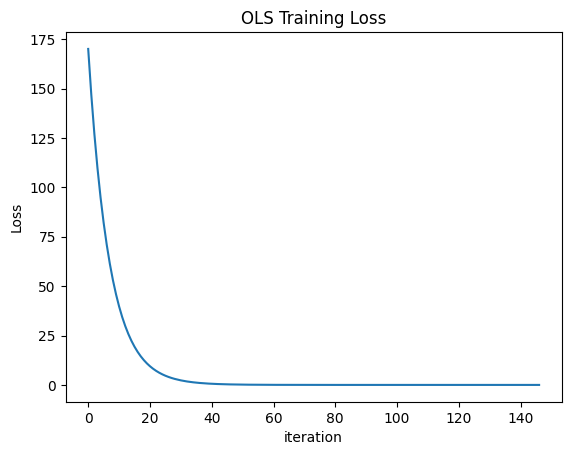


 Theta: [ 5.00293128 10.98873294] 
 Norm of Theta: 12.074004012300998 
 Testing MSELoss: 7.113216624524173e-05


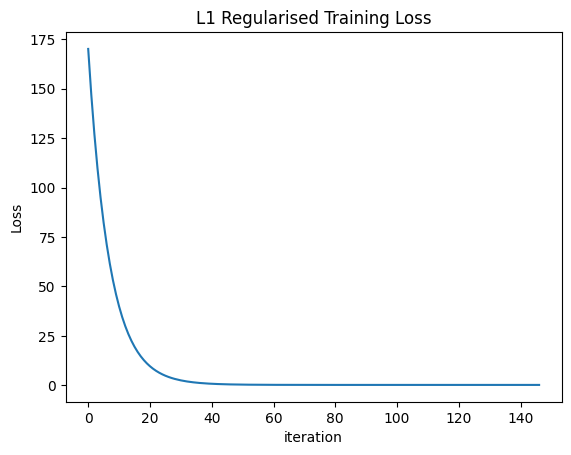


 Theta: [ 5.03848665 10.78503368] 
 Norm of Theta: 11.903919490265675 
 Testing MSELoss: 0.025010994877640726


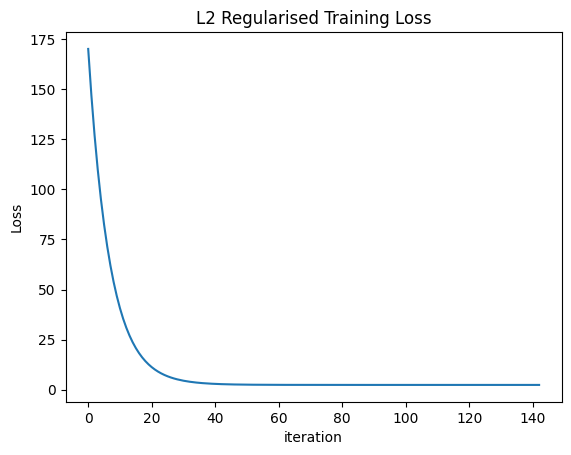

In [28]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def test_synthetic_data_sgd(X, y, n_iter = 2000, penalty=None, lambd=0):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)
  # Given that we want to get theta as the weights of the linear equation, we won't
  # standardize in this section

  alpha = 0.03  # Learning Rate

  # # Train the model
  lr_model = LinearRegression(alpha = alpha, tol=1e-4, max_iter = n_iter, penalty=penalty, lambd=lambd)
  lr_model.fit(X_train,y_train[:, 0])
  y_predict = lr_model.predict(X_test)
  loss = sklearn.metrics.mean_squared_error(y_predict, y_test)
  print()
  print(" Theta: {} \n Norm of Theta: {} \n Testing MSELoss: {}".format(lr_model.theta_, np.linalg.norm(lr_model.theta_, ord=2), loss))

  loss_history = lr_model.hist_cost_
  plt.plot(range(len(loss_history)), loss_history)
  plt.title("OLS Training Loss")
  plt.xlabel("iteration")
  plt.ylabel("Loss")
  if penalty == "l1":
    plt.title("L1 Regularised Training Loss")
  elif penalty == "l2":
    plt.title("L2 Regularised Training Loss")
  plt.show()

test_synthetic_data_sgd(X, y_ideal, 500)
test_synthetic_data_sgd(X, y_ideal, 500, "l1", 0.02)
test_synthetic_data_sgd(X, y_ideal, 500, "l2", 0.02)

## **1.3. Effect of polynomial degree on training and validation error [5 pts, Manually Graded]**

Now, we consider a dataset that was generated using some higher degree polynomial function of the input variable. We do not know the degree of the underlying polynomial. Let us assume it to be an unknown value "p" and try to estimate it.

Polynomial regression hypothesis for one input variable  or feature (x) can be written as:
> $y = w_0 + w_1x + w_2x^2 + ... + w_px^p $

If you observe carefully, this can still be solved as a linear regression, where, instead of just 2 weights, we have p+1 weights, and the new features are higher order terms of the original feature. Using this idea, in this section, we will investigate how changing the assumed polynomial degree "p" in our model affects the training and validation error.

In [29]:
if not os.path.exists("cis519_hw2_poly_reg.csv"):
    !gdown --id 1F5cGpc9ayxf49RQskiJFlL0v5LzCP7dn

poly_reg_df = pd.read_csv('cis519_hw2_poly_reg.csv')

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1F5cGpc9ayxf49RQskiJFlL0v5LzCP7dn
To: /content/cis519_hw2_poly_reg.csv
100% 50.7k/50.7k [00:00<00:00, 70.7MB/s]


In [30]:
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LinearRegressionSklearn

def polynomial_regression(poly_reg_df, degrees):
    """
    Runs polynomial regression on the dataset 'poly_reg_df' for all the powers in 'degrees'
    """

    loss_train_list = []
    loss_test_list = []

    # seperating features and target
    X_base = poly_reg_df.iloc[:, :-1].values
    y = poly_reg_df.iloc[:, -1].values

    # iterating over all degrees
    for d in degrees:

        # 1. Transform the base feature X_base into its polynomial features of degree 'd' using PolynomialFeatures from sklearn.preprocessing
        # Set include_bias to be False
      poly = PolynomialFeatures(degree=d, include_bias=False)
      X_poly = poly.fit_transform(X_base)

      # 2. Preprocessing and splitting into train/test (70-30 ratio and random_state as 42)
      X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

       # 3. Scale X_train and X_test appropriately
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

        # 4. Use scikit-learn's LinearRegression (imported as LinearRegressionSklearn for you) to
        # fit a linear model between the scaled version of X_train and y_train
      reg = LinearRegressionSklearn()
      reg.fit(X_train, y_train)

       # 5. Obtain predictions of the model on train and test data
      y_train_pred = reg.predict(X_train)
      y_test_pred = reg.predict(X_test)

     # 6. Compute the mean squared error and store it in loss_train and loss_test
      loss_train = sklearn.metrics.mean_squared_error(y_train_pred, y_train)
      loss_test = sklearn.metrics.mean_squared_error(y_test_pred, y_test)

     # 7. Append loss_train to loss_train_list and loss_test to loss_test_list
      loss_train_list.append(loss_train)
      loss_test_list.append(loss_test)

    return loss_train_list, loss_test_list

8 8


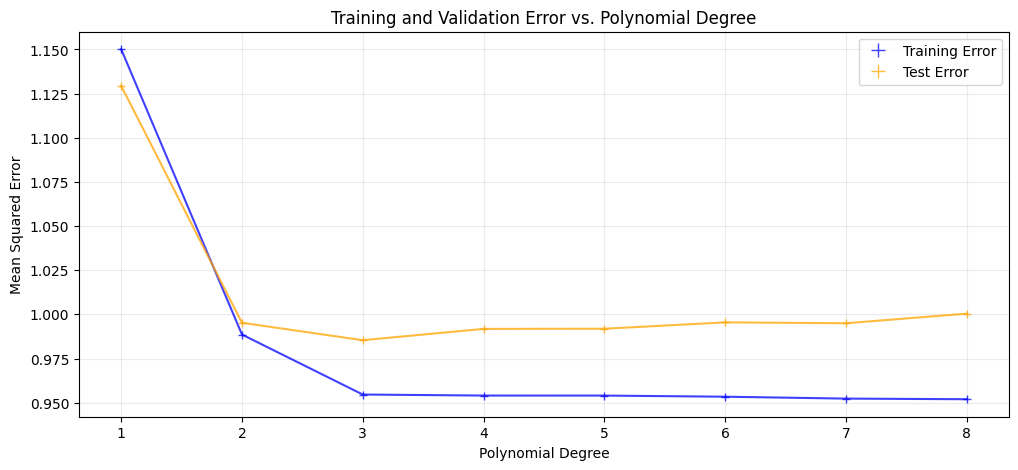

In [31]:
degrees = np.arange(1, 9)

loss_train_list, loss_test_list = polynomial_regression(poly_reg_df, degrees)
print(len(loss_train_list), len(loss_test_list))

# TODO START:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Colors for training and test errors
colors = {"Training Error": "blue", "Test Error": "orange"}

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the training and test error as a function of degree
ax.plot(degrees, loss_train_list, color=colors["Training Error"], marker='+', alpha=0.75, label="Training Error")
ax.plot(degrees, loss_test_list, color=colors["Test Error"], marker='+', alpha=0.75, label="Test Error")

# Add grid
ax.grid(True, alpha=0.25)

# Set axis labels and title
ax.set_xlabel("Polynomial Degree")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Training and Validation Error vs. Polynomial Degree")

# Create legend
legend_handles = [Line2D([0], [0], color=color, marker='+', alpha=0.75,
                         linestyle='None', markersize=10, label=label)
                  for label, color in colors.items()]

ax.legend(handles=legend_handles, loc="upper right")

# Show the plot
plt.show()

# TODO END

### **Attach the plot to your written homework solutions. Describe the trends in the plot obtained. Briefly explain the reasoning behind why this would happen.**

## **1.4. Effect of learning rate on gradient descent [5 pts, Manually Graded]**



Run the below cell to download the dataset.

In [32]:
if not os.path.exists("cis519_hw2_admit.csv"):
    !gdown --id 1CSD1vA9qZucuevxCuaOwr91tBaZcjNNh

train_df = pd.read_csv("cis519_hw2_admit.csv")

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CSD1vA9qZucuevxCuaOwr91tBaZcjNNh
To: /content/cis519_hw2_admit.csv
100% 3.61k/3.61k [00:00<00:00, 14.8MB/s]


The dataset contains two features - scores in two exams and the target variable is whether the student was admitted into a college or not. Your task for this question is to use this dataset and plot the variation of cost function with respect to the number of gradient descent iterations for different learning rates. Perform the following steps.

1. Scale the features using StandardScaler
2. For each of the learning rates - {0.001, 0.01, 0.03, 0.1, 1.0}, fit a linear regression model to the scaled data by running a maximum of 100 iterations of gradient descent with L2 penalty and $\lambda$ as 0.001.
3. Show the variation of the cost (stored in `hist_cost_`) with respect to the number of iterations for all the learning rates in the same plot.


### Submit the plot along with the written homework solutions. The plot should have an appropriate title, axes labels, and legend. Briefly comment on the effect of increasing learning rate and what would be the best learning rate among the four values based on the plot.

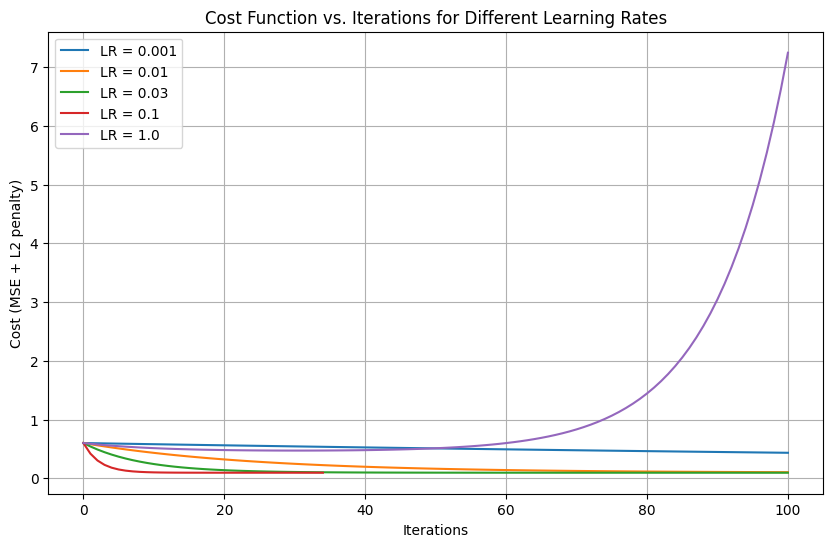

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

 # seperating features and target
X_base = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_base)

class LinearRegression:
    def __init__(self, alpha=0.01, tol=1e-4, max_iter=100, theta_init=None, penalty=None, lambd=0.001):
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
        self.penalty = penalty
        self.lambd = lambd
        self.theta_init = theta_init
        self.theta_ = None
        self.hist_cost_ = None
        self.hist_theta_ = None

    def compute_cost(self, theta, X, y):
        hypothesis = np.dot(X, theta)
        mse_cost = (1 / X.shape[0]) * np.sum((hypothesis - y) ** 2)
        reg_cost = self.lambd * np.sum(theta[1:] ** 2)  # L2 regularization term (ignore bias term)
        return mse_cost + reg_cost

    def compute_gradient(self, theta, X, y):
        gradient = -2 / X.shape[0] * X.T @ (y - X @ theta)
        gradient[1:] += self.lambd * 2 * theta[1:]  # Apply regularization to the gradient, excluding bias
        return gradient

    def has_converged(self, theta_old, theta_new):
        return np.linalg.norm(theta_new - theta_old, ord=2) <= self.tol

    def fit(self, X, y):
        N, D = X.shape
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))  # Add a column of ones for the bias term

        if self.theta_init is None:
            theta_old = np.zeros((D + 1,))
        else:
            theta_old = self.theta_init

        self.hist_theta_ = np.array([theta_old])
        self.hist_cost_ = np.array([self.compute_cost(theta_old, X, y)])

        for i in range(self.max_iter):
            theta_new = theta_old - self.alpha * self.compute_gradient(theta_old, X, y)
            self.hist_theta_ = np.vstack([self.hist_theta_, theta_new])
            cost_new = self.compute_cost(theta_new, X, y)
            self.hist_cost_ = np.append(self.hist_cost_, cost_new)

            if self.has_converged(theta_old, theta_new):
                break

            theta_old = theta_new

        self.theta_ = theta_new

# Set up the learning rates to test and store the number of iterations for each learning rate
learning_rates = [0.001, 0.01, 0.03, 0.1, 1.0]
iterations_per_lr = []

# Initialize list to store cost histories for each learning rate
cost_histories = []

# Run the model for each learning rate and store the cost history and iteration counts
for lr in learning_rates:
    reg = LinearRegression(alpha=lr, max_iter=100)
    reg.fit(X_scaled, y)
    cost_histories.append(reg.hist_cost_)
    iterations_per_lr.append(len(reg.hist_cost_) - 1)  # Store the number of iterations for this learning rate

# Plot the cost function vs. iterations for each learning rate
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(np.arange(len(cost_histories[i])), cost_histories[i], label=f'LR = {lr}')

plt.xlabel('Iterations')
plt.ylabel('Cost (MSE + L2 penalty)')
plt.title('Cost Function vs. Iterations for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()




# Download the .ipynb notebook and submit it on Gradescope.

# Again, remember to add plots of 1.3 and 1.4 to your written HW1 answer-sheets. Well done folks! :)